<a href="https://colab.research.google.com/github/HSS107048212/Burnout-Analysis-and-Prediction/blob/main/112034602_%E9%99%B3%E7%9A%86%E9%8C%AB_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

參考資料:

https://www.kaggle.com/code/willribeiro/burnout-analysis-and-prediction

https://www.kaggle.com/code/ushasridevarakonda/employee-burnout-prediction

https://www.kaggle.com/code/blurredmachine/employee-burn-rate-analysis-eda-viz-pred







### Import Package

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
# Category Encoder (categorical variable)
from sklearn.preprocessing import LabelEncoder
# Min max normalization (numerical variable)
from sklearn.preprocessing import MinMaxScaler
# Model (can also view the scikit learn to choose the model)
from sklearn.linear_model import LinearRegression
os.getcwd()

'/content'

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import scipy.stats as st

### Read data

In [ ]:
df = pd.read_csv(r'./train.csv')
print('viwe the data shape', df.shape)
df.head()

viwe the data shape (10108, 9)


,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,0,2008/9/30,Female,Service,No,2,3.0,3.8,0.16
1,1,2008/11/30,Male,Service,Yes,1,2.0,5.0,0.36
2,2,2008/3/10,Female,Product,Yes,2,NaN,5.8,0.49
3,3,2008/11/3,Male,Service,Yes,1,1.0,2.6,0.20
4,4,2008/7/24,Female,Service,No,3,7.0,6.9,0.52


### Data Preprocessing

### Check Missing Value

In [ ]:
df.isna().sum()
df.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,0,2008/9/30,Female,Service,No,2,3.0,3.8,0.16
1,1,2008/11/30,Male,Service,Yes,1,2.0,5.0,0.36
2,2,2008/3/10,Female,Product,Yes,2,NaN,5.8,0.49
3,3,2008/11/3,Male,Service,Yes,1,1.0,2.6,0.20
4,4,2008/7/24,Female,Service,No,3,7.0,6.9,0.52


In [ ]:
df = df.dropna()
df = df.drop(['Employee ID','Date of Joining','Gender','Company Type','WFH Setup Available'],axis=1)
x = df[df.columns[0:3]]
y = df[df.columns[3]]
print(x)

df.head()

       Designation  Resource Allocation  Mental Fatigue Score
0                2                  3.0                   3.8
1                1                  2.0                   5.0
3                1                  1.0                   2.6
4                3                  7.0                   6.9
5                2                  4.0                   3.6
...            ...                  ...                   ...
10102            4                  8.0                   6.2
10103            3                  6.0                   5.9
10104            3                  6.0                   6.3
10105            3                  5.0                   5.7
10106            2                  3.0                   5.5

[8233 rows x 3 columns]


,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,2,3.0,3.8,0.16
1,1,2.0,5.0,0.36
3,1,1.0,2.6,0.20
4,3,7.0,6.9,0.52
5,2,4.0,3.6,0.29


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8233 entries, 0 to 10106
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Designation           8233 non-null   int64  
 1   Resource Allocation   8233 non-null   float64
 2   Mental Fatigue Score  8233 non-null   float64
 3   Burn Rate             8233 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 321.6 KB


In [ ]:
df.corr()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
Designation,1.000000,0.879168,0.692255,0.737306
Resource Allocation,0.879168,1.000000,0.799909,0.857002
Mental Fatigue Score,0.692255,0.799909,1.000000,0.943678
Burn Rate,0.737306,0.857002,0.943678,1.000000


#### EDA

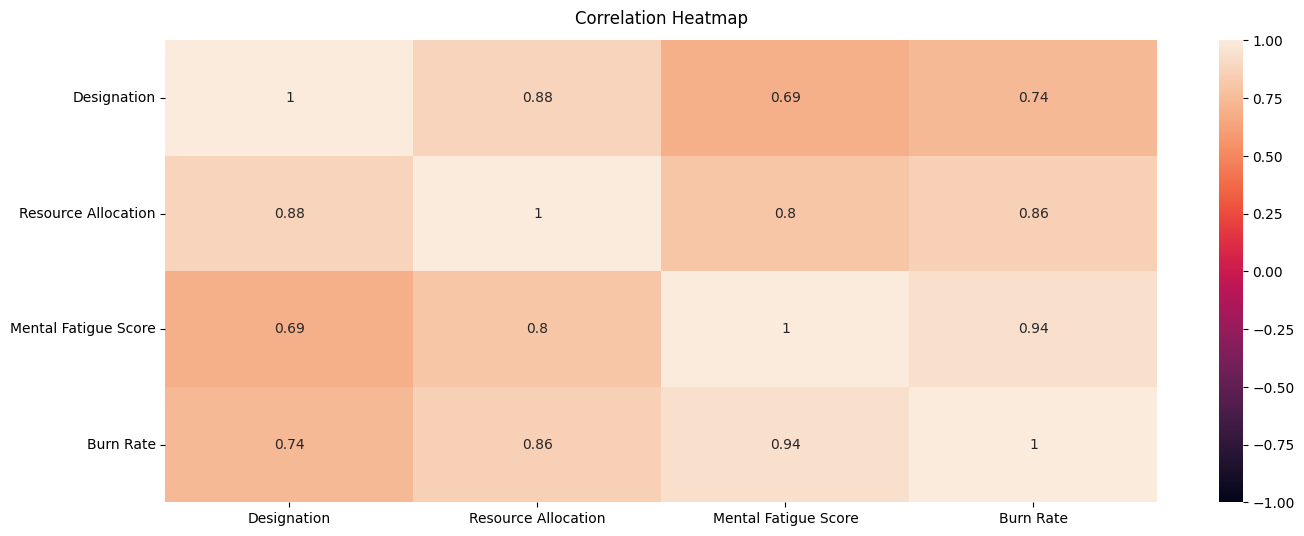

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.savefig("correlation_heatmap.png")

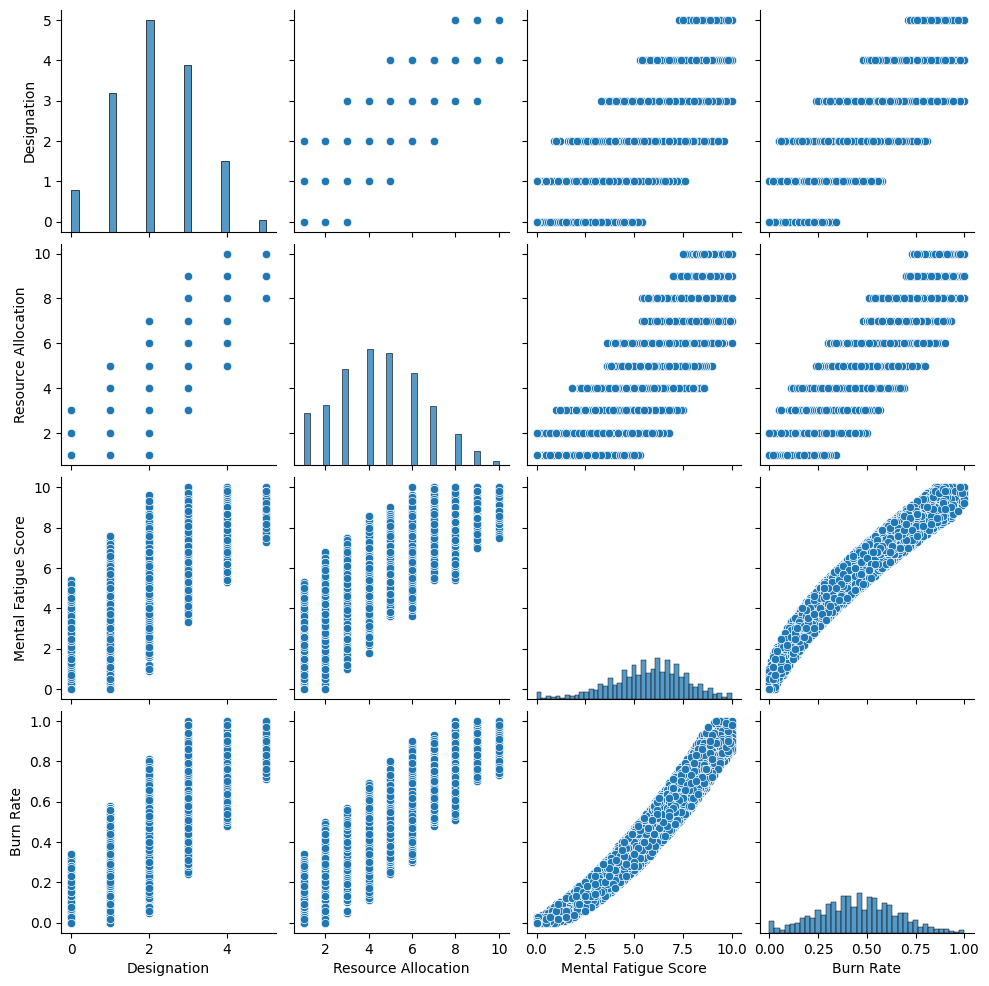

In [ ]:
sns_plot = sns.pairplot(df, height=2.5)
sns_plot.savefig("pairplot.png")

In [ ]:
def normalize_features(original_data):
    fitted_data, fitted_lambda = stats.boxcox(original_data)
    fig, ax = plt.subplots(1, 2)

    # plotting the original data(non-normal) and
    # fitted data (normal)
    sns.distplot(original_data, hist = False, kde = True,
                kde_kws = {'shade': True, 'linewidth': 2},
                label = "Non-Normal", color ="green", ax = ax[0])

    sns.distplot(fitted_data, hist = False, kde = True,
                kde_kws = {'shade': True, 'linewidth': 2},
                label = "Normal", color ="green", ax = ax[1])

    # adding legends to the subplots
    plt.legend(loc = "upper right")

    # rescaling the subplots
    fig.set_figheight(5)
    fig.set_figwidth(10)
    return fitted_data

<ipython-input-37-e3440b8b4f00>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(original_data, hist = False, kde = True,
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
<ipython-input-37-e3440b8b4f00>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kd

array([1.68484105, 0.90223051, 0.        , ..., 3.69668907, 3.06533141,
       1.68484105])

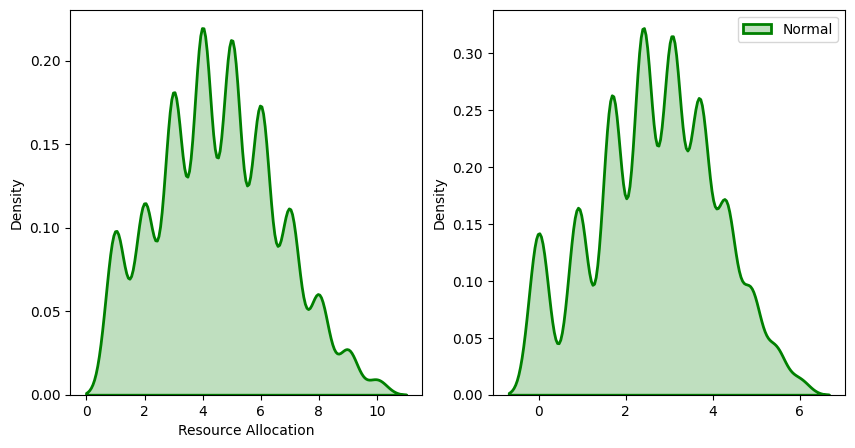

In [ ]:
original_data = df.drop(df[df["Resource Allocation"] <= 0.0].index)["Resource Allocation"]
normalize_features(original_data)

<ipython-input-37-e3440b8b4f00>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(original_data, hist = False, kde = True,
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
<ipython-input-37-e3440b8b4f00>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kd

array([3.36174511, 5.02618778, 1.8112542 , ..., 6.93216559, 6.04043506,
       5.74767472])

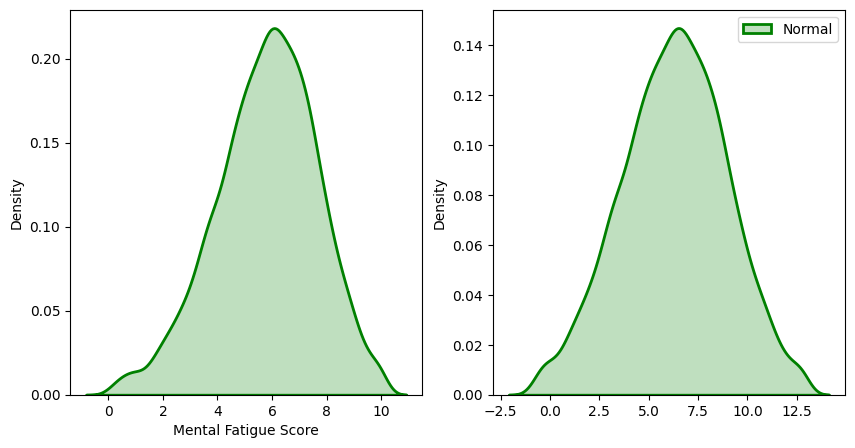

In [ ]:
original_data = df.drop(df[df["Mental Fatigue Score"] <= 0.0].index)["Mental Fatigue Score"]
normalize_features(original_data)

<ipython-input-37-e3440b8b4f00>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(original_data, hist = False, kde = True,
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
<ipython-input-37-e3440b8b4f00>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kd

array([0.80653203, 0.        , 0.        , ..., 1.40149208, 1.40149208,
       0.80653203])

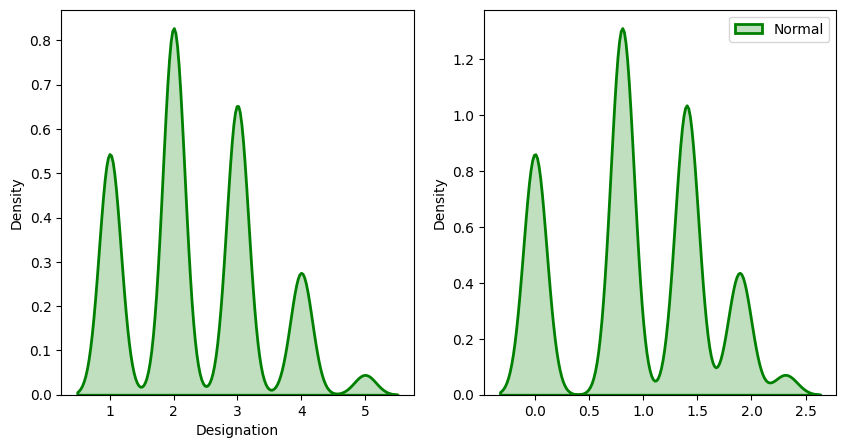

In [ ]:
original_data = df.drop(df[df["Designation"] <= 0.0].index)["Designation"]
normalize_features(original_data)

<ipython-input-37-e3440b8b4f00>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(original_data, hist = False, kde = True,
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
<ipython-input-37-e3440b8b4f00>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kd

array([-0.94070187, -0.68840499, -0.8872663 , ..., -0.39447227,
       -0.56074391, -0.6413109 ])

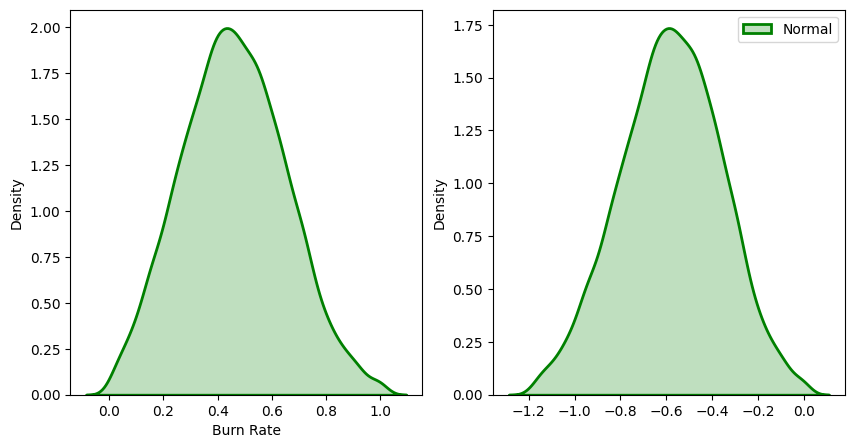

In [ ]:
original_data = df.drop(df[df["Burn Rate"] <= 0.0].index)["Burn Rate"]
normalize_features(original_data)

### Training (model construction)

In [ ]:
x = np.array(df.drop('Burn Rate', axis=1))
y = np.array(df['Burn Rate'])

In [ ]:
model = LinearRegression().fit(x, y)

### Cross validation
- usually we will do cross validation to evaluate the generalization of model
- or you can just use ```sklearn.model_selection.train_test_split``` to evaluate your model

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate
# directly use cross_val_score
scores = cross_val_score(model, x, y, cv=5)
print("R2: %0.2f (std: %0.2f)" % (scores.mean(), scores.std()))
print(scores)
# need other scoring
scores = cross_validate(model, x, y, cv=5,
                       scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error'))
print("====================================")
print("R2: {} (std: {})".format(scores['test_r2'].mean(), scores['test_r2'].std()))
print("MSE: {} (std: {})".format(-scores['test_neg_mean_squared_error'].mean(), scores['test_neg_mean_squared_error'].std()))
print("MAPE: {} (std: {})".format(-scores['test_neg_mean_absolute_percentage_error'].mean(), scores['test_neg_mean_absolute_percentage_error'].std()))

R2: 0.92 (std: 0.00)
[0.92296044 0.91829899 0.92404746 0.91874412 0.91373241]
R2: 0.9195566849884015 (std: 0.003685563266632016)
MSE: 0.003158388837957508 (std: 7.660468292325802e-05)
MAPE: 3158693666869.661 (std: 781649496697.1427)


### Prediction
1. read data
2. model prediction
3. to_csv

In [ ]:
df_test = pd.read_csv(r'./test.csv')
# df_test = df_test.dropna()
a = list(df_test)
for i in range(len(a)):
    df_test[a[i]] = df_test[a[i]].fillna(0)
df_test = df_test.drop(['Employee ID','Date of Joining','Gender','Company Type','WFH Setup Available'],axis=1)
print(df_test.shape)
df_test.head()

(1980, 3)


,Designation,Resource Allocation,Mental Fatigue Score
0,0,1.0,0.0
1,3,8.0,7.9
2,4,9.0,8.1
3,1,3.0,5.7
4,3,5.0,0.0


### Same preprocessing step as training procedure
- can write it like a function or pipeline

In [ ]:
df_test.isna().sum()

Designation             0
Resource Allocation     0
Mental Fatigue Score    0
dtype: int64

In [ ]:
X_test = df_test[df_test.columns]
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [ ]:
# 将小于1的数值转换为0
y_pred[y_pred < 0] = 0

### Output .csv for submission

In [ ]:
df_ans = pd.DataFrame(y_pred.astype(float), columns=['Burn Rate'])
df_ans.to_csv('mySubmission.csv', index_label='Employee ID')

### Some Tips
1. try different scaling approach (numerical variable)
2. encoding method
3. different model
4. feature engineering (some different transformation)
5. do some data exploration to see other pattern
6. hyperparameter

### Other Complementary
- pipeline: https://scikit-learn.org/stable/modules/compose.html#pipeline
- also can try some basic deep learning model (ANN)